```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Linear Regression in Python

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install linearmodels

  Obtaining dependency information for linearmodels from https://files.pythonhosted.org/packages/5e/54/39a20f68c49ec8329db26ef7628a54728f0c4cfb4d7bbae8e87d9f662dce/linearmodels-5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata


  Obtaining dependency information for Cython>=0.29.34 from https://files.pythonhosted.org/packages/0d/c7/cb436626760491badd92ac1c8e1a165964b4eb2ceedaaaa90de1e1860be7/Cython-3.0.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pyhdfe>=0.1 from https://files.pythonhosted.org/packages/2f/51/cb006fbc08c32f161035fb19ca718250eb5f6d0692ea6dcc1e62c3e556a2/pyhdfe-0.2.0-py3-none-any.whl.metadata


  Obtaining dependency information for formulaic>=0.6.5 from https://files.pythonhosted.org/packages/ae/f0/ff275c0009f0037c381c6e3a94049b9792df7d7f437c5ccd0c7aefca5f22/formulaic-0.6.6-py3-none-any.whl.metadata


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.9 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.8/1.8 MB 58.8 MB/s eta 0:00:01

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.6 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 16.9 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


## Overview

Linear regression is a standard tool for analyzing the relationship between two or more variables.

In this lecture, we'll use the Python package `statsmodels` to estimate, interpret, and visualize linear regression models.

Along the way, we'll discuss a variety of topics, including

- simple and multivariate linear regression
- visualization
- endogeneity and omitted variable bias
- two-stage least squares

As an example, we will replicate results from Acemoglu, Johnson and Robinson's seminal paper {cite}`Acemoglu2001`.

* You can download a copy [here](https://economics.mit.edu/research/publications/colonial-origins-comparative-development-empirical-investigation).

In the paper, the authors emphasize the importance of institutions in economic development.

The main contribution is the use of settler mortality rates as a source of *exogenous* variation in institutional differences.

Such variation is needed to determine whether it is institutions that give rise to greater economic growth, rather than the other way around.

Let's start with some imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import seaborn as sns
sns.set_theme()

### Prerequisites

This lecture assumes you are familiar with basic econometrics.

For an introductory text covering these topics, see, for example,
{cite}`Wooldridge2015`.

## Simple Linear Regression

{cite}`Acemoglu2001` wish to determine whether or not differences in institutions can help to explain observed economic outcomes.

How do we measure *institutional differences* and *economic outcomes*?

In this paper,

- economic outcomes are proxied by log GDP per capita in 1995, adjusted for exchange rates.
- institutional differences are proxied by an index of protection against expropriation on average over 1985-95, constructed by the [Political Risk Services Group](https://www.prsgroup.com/).

These variables and other data used in the paper are available for download on Daron Acemoglu's [webpage](https://economics.mit.edu/people/faculty/daron-acemoglu/data-archive).

We will use pandas' `.read_stata()` function to read in data contained in the `.dta` files to dataframes

In [3]:
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's use a scatterplot to see whether any obvious relationship exists
between GDP per capita and the protection against
expropriation index

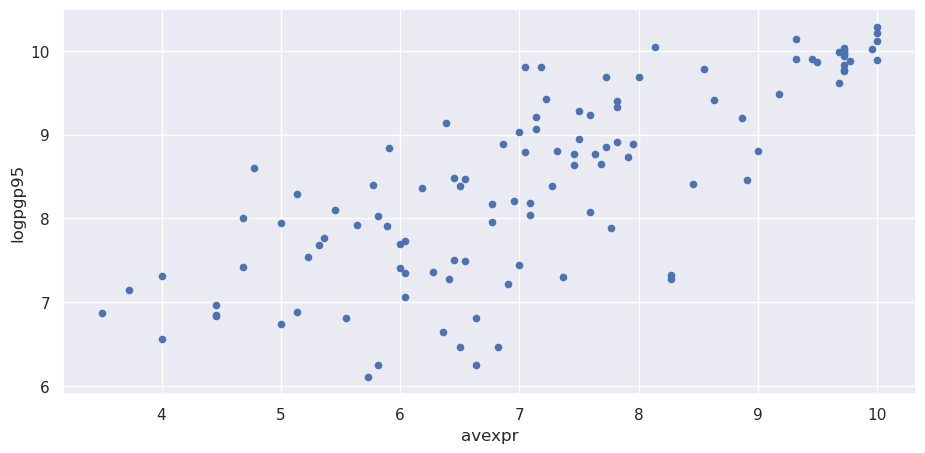

In [4]:
df1.plot(x='avexpr', y='logpgp95', kind='scatter')
plt.show()

The plot shows a fairly strong positive relationship between
protection against expropriation and log GDP per capita.

Specifically, if higher protection against expropriation is a measure of
institutional quality, then better institutions appear to be positively
correlated with better economic outcomes (higher GDP per capita).

Given the plot, choosing a linear model to describe this relationship
seems like a reasonable assumption.

We can write our model as

$$
{logpgp95}_i = \beta_0 + \beta_1 {avexpr}_i + u_i
$$

where:

- $\beta_0$ is the intercept of the linear trend line on the
  y-axis
- $\beta_1$ is the slope of the linear trend line, representing
  the *marginal effect* of protection against risk on log GDP per
  capita
- $u_i$ is a random error term (deviations of observations from
  the linear trend due to factors not included in the model)

Visually, this linear model involves choosing a straight line that best
fits the data, as in the following plot (Figure 2 in {cite}`Acemoglu2001`)

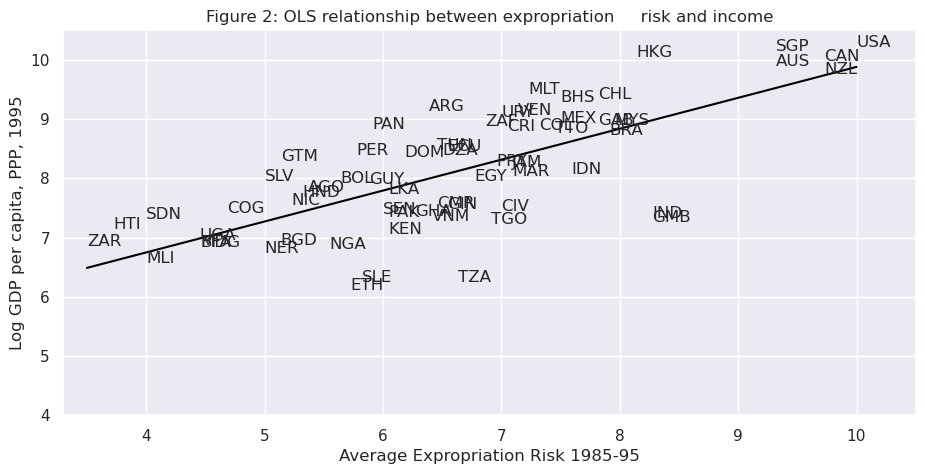

In [5]:
# Dropping NA's is required to use numpy's polyfit
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr'])

# Use only 'base sample' for plotting purposes
df1_subset = df1_subset[df1_subset['baseco'] == 1]

X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']

# Replace markers with country labels
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Average Expropriation Risk 1985-95')
ax.set_ylabel('Log GDP per capita, PPP, 1995')
ax.set_title('Figure 2: OLS relationship between expropriation \
    risk and income')
plt.show()

The most common technique to estimate the parameters ($\beta$'s)
of the linear model is Ordinary Least Squares (OLS).

As the name implies, an OLS model is solved by finding the parameters
that minimize *the sum of squared residuals*, i.e.

$$
\underset{\hat{\beta}}{\min} \sum^N_{i=1}{\hat{u}^2_i}
$$

where $\hat{u}_i$ is the difference between the observation and
the predicted value of the dependent variable.

To estimate the constant term $\beta_0$, we need to add a column
of 1's to our dataset (consider the equation if $\beta_0$ was
replaced with $\beta_0 x_i$ and $x_i = 1$)

In [6]:
df1['const'] = 1

Now we can construct our model in `statsmodels` using the OLS function.

We will use `pandas` dataframes with `statsmodels`, however standard arrays can also be used as arguments

In [7]:
reg1 = sm.OLS(endog=df1['logpgp95'], exog=df1[['const', 'avexpr']], \
    missing='drop')
type(reg1)

statsmodels.regression.linear_model.OLS

So far we have simply constructed our model.

We need to use `.fit()` to obtain parameter estimates
$\hat{\beta}_0$ and $\hat{\beta}_1$

In [8]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

We now have the fitted regression model stored in `results`.

To view the OLS regression results, we can call the `.summary()`
method.

Note that an observation was mistakenly dropped from the results in the
original paper (see the note located in `maketable2.do` from Acemoglu's webpage), and thus the
coefficients differ slightly.

In [9]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           4.16e-24
Time:                        01:25:31   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

From our results, we see that

- The intercept $\hat{\beta}_0 = 4.63$.
- The slope $\hat{\beta}_1 = 0.53$.
- The positive $\hat{\beta}_1$ parameter estimate implies that.
  institutional quality has a positive effect on economic outcomes, as
  we saw in the figure.
- The p-value of 0.000 for $\hat{\beta}_1$ implies that the
  effect of institutions on GDP is statistically significant (using p <
  0.05 as a rejection rule).
- The R-squared value of 0.611 indicates that around 61% of variation
  in log GDP per capita is explained by protection against
  expropriation.

Using our parameter estimates, we can now write our estimated
relationship as

$$
\widehat{logpgp95}_i = 4.63 + 0.53 \ {avexpr}_i
$$

This equation describes the line that best fits our data, as shown in
Figure 2.

We can use this equation to predict the level of log GDP per capita for
a value of the index of expropriation protection.

For example, for a country with an index value of 7.07 (the average for
the dataset), we find that their predicted level of log GDP per capita
in 1995 is 8.38.

In [10]:
mean_expr = np.mean(df1_subset['avexpr'])
mean_expr

6.515625

In [11]:
predicted_logpdp95 = 4.63 + 0.53 * 7.07
predicted_logpdp95

8.3771

An easier (and more accurate) way to obtain this result is to use
`.predict()` and set $constant = 1$ and
${avexpr}_i = mean\_expr$

In [12]:
results.predict(exog=[1, mean_expr])

array([8.09156367])

We can obtain an array of predicted ${logpgp95}_i$ for every value
of ${avexpr}_i$ in our dataset by calling `.predict()` on our
results.

Plotting the predicted values against ${avexpr}_i$ shows that the
predicted values lie along the linear line that we fitted above.

The observed values of ${logpgp95}_i$ are also plotted for
comparison purposes

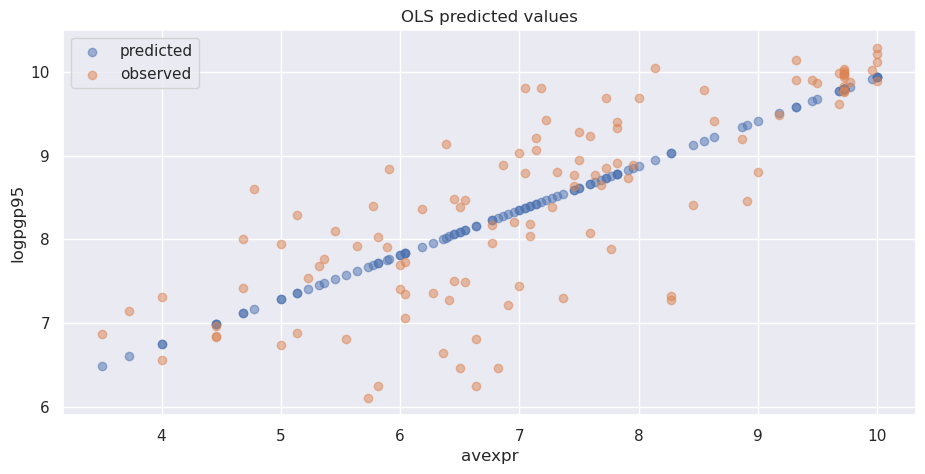

In [13]:
# Drop missing observations from whole sample

df1_plot = df1.dropna(subset=['logpgp95', 'avexpr'])

# Plot predicted values

fix, ax = plt.subplots()
ax.scatter(df1_plot['avexpr'], results.predict(), alpha=0.5,
        label='predicted')

# Plot observed values

ax.scatter(df1_plot['avexpr'], df1_plot['logpgp95'], alpha=0.5,
        label='observed')

ax.legend()
ax.set_title('OLS predicted values')
ax.set_xlabel('avexpr')
ax.set_ylabel('logpgp95')
plt.show()

## Extending the Linear Regression Model

So far we have only accounted for institutions affecting economic
performance - almost certainly there are numerous other factors
affecting GDP that are not included in our model.

Leaving out variables that affect $logpgp95_i$ will result in **omitted variable bias**, yielding biased and inconsistent parameter estimates.

We can extend our bivariate regression model to a **multivariate regression model** by adding in other factors that may affect $logpgp95_i$.

{cite}`Acemoglu2001` consider other factors such as:

- the effect of climate on economic outcomes; latitude is used to proxy
  this
- differences that affect both economic performance and institutions,
  eg. cultural, historical, etc.; controlled for with the use of
  continent dummies

Let's estimate some of the extended models considered in the paper
(Table 2) using data from `maketable2.dta`

In [14]:
df2 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable2.dta?raw=true')

# Add constant term to dataset
df2['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df2['logpgp95'], df2[X1], missing='drop').fit()
reg2 = sm.OLS(df2['logpgp95'], df2[X2], missing='drop').fit()
reg3 = sm.OLS(df2['logpgp95'], df2[X3], missing='drop').fit()

Now that we have fitted our model, we will use `summary_col` to
display the results in a single table (model numbers correspond to those
in the paper)

In [15]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'avexpr',
                                             'lat_abst',
                                             'asia',
                                             'africa'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

        Table 2 - OLS Regressions
                 Model 1 Model 3 Model 4 
-----------------------------------------
const            4.63*** 4.87*** 5.85*** 
                 (0.30)  (0.33)  (0.34)  
avexpr           0.53*** 0.46*** 0.39*** 
                 (0.04)  (0.06)  (0.05)  
lat_abst                 0.87*   0.33    
                         (0.49)  (0.45)  
asia                             -0.15   
                                 (0.15)  
africa                           -0.92***
                                 (0.17)  
other                            0.30    
                                 (0.37)  
R-squared        0.61    0.62    0.72    
R-squared Adj.   0.61    0.62    0.70    
R-squared        0.61    0.62    0.72    
No. observations 111     111     111     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Endogeneity

As {cite}`Acemoglu2001` discuss, the OLS models likely suffer from
**endogeneity** issues, resulting in biased and inconsistent model
estimates.

Namely, there is likely a two-way relationship between institutions and
economic outcomes:

- richer countries may be able to afford or prefer better institutions
- variables that affect income may also be correlated with
  institutional differences
- the construction of the index may be biased; analysts may be biased
  towards seeing countries with higher income having better
  institutions

To deal with endogeneity, we can use **two-stage least squares (2SLS)
regression**, which is an extension of OLS regression.

This method requires replacing the endogenous variable
${avexpr}_i$ with a variable that is:

1. correlated with ${avexpr}_i$
1. not correlated with the error term (ie. it should not directly affect
   the dependent variable, otherwise it would be correlated with
   $u_i$ due to omitted variable bias)

The new set of regressors is called an **instrument**, which aims to
remove endogeneity in our proxy of institutional differences.

The main contribution of {cite}`Acemoglu2001` is the use of settler mortality
rates to instrument for institutional differences.

They hypothesize that higher mortality rates of colonizers led to the
establishment of institutions that were more extractive in nature (less
protection against expropriation), and these institutions still persist
today.

Using a scatterplot (Figure 3 in {cite}`Acemoglu2001`), we can see protection
against expropriation is negatively correlated with settler mortality
rates, coinciding with the authors' hypothesis and satisfying the first
condition of a valid instrument.

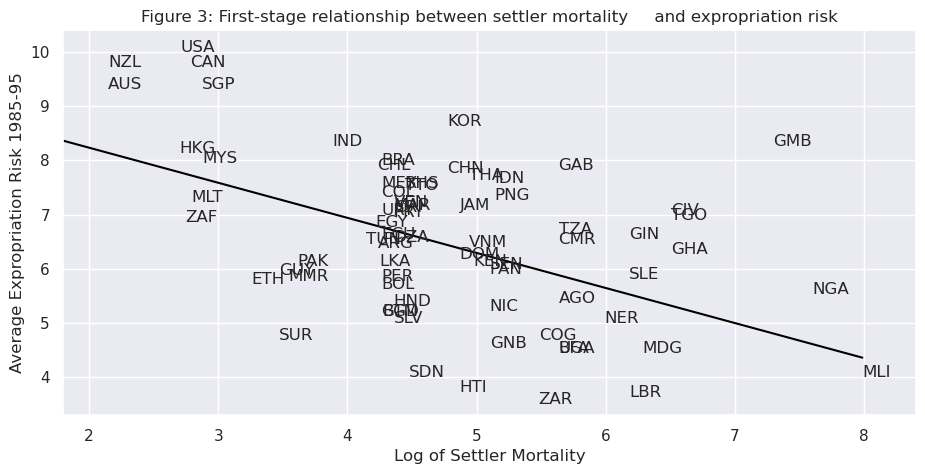

In [16]:
# Dropping NA's is required to use numpy's polyfit
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])

X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

# Replace markers with country labels
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([1.8,8.4])
ax.set_ylim([3.3,10.4])
ax.set_xlabel('Log of Settler Mortality')
ax.set_ylabel('Average Expropriation Risk 1985-95')
ax.set_title('Figure 3: First-stage relationship between settler mortality \
    and expropriation risk')
plt.show()

The second condition may not be satisfied if settler mortality rates in the 17th to 19th centuries have a direct effect on current GDP (in addition to their indirect effect through institutions).

For example, settler mortality rates may be related to the current disease environment in a country, which could affect current economic performance.

{cite}`Acemoglu2001` argue this is unlikely because:

- The majority of settler deaths were due to malaria and yellow fever
  and had a limited effect on local people.
- The disease burden on local people in Africa or India, for example,
  did not appear to be higher than average, supported by relatively
  high population densities in these areas before colonization.

As we appear to have a valid instrument, we can use 2SLS regression to
obtain consistent and unbiased parameter estimates.

**First stage**

The first stage involves regressing the endogenous variable
(${avexpr}_i$) on the instrument.

The instrument is the set of all exogenous variables in our model (and
not just the variable we have replaced).

Using model 1 as an example, our instrument is simply a constant and
settler mortality rates ${logem4}_i$.

Therefore, we will estimate the first-stage regression as

$$
{avexpr}_i = \delta_0 + \delta_1 {logem4}_i + v_i
$$

The data we need to estimate this equation is located in
`maketable4.dta` (only complete data, indicated by `baseco = 1`, is
used for estimation)

In [17]:
# Import and select the data
df4 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable4.dta?raw=true')
df4 = df4[df4['baseco'] == 1]

# Add a constant variable
df4['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df4['avexpr'],
                    df4[['const', 'logem4']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.08e-05
Time:                        01:25:33   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

**Second stage**

We need to retrieve the predicted values of ${avexpr}_i$ using
`.predict()`.

We then replace the endogenous variable ${avexpr}_i$ with the
predicted values $\widehat{avexpr}_i$ in the original linear model.

Our second stage regression is thus

$$
{logpgp95}_i = \beta_0 + \beta_1 \widehat{avexpr}_i + u_i
$$

In [18]:
df4['predicted_avexpr'] = results_fs.predict()

results_ss = sm.OLS(df4['logpgp95'],
                    df4[['const', 'predicted_avexpr']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.66e-10
Time:                        01:25:33   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

The second-stage regression results give us an unbiased and consistent
estimate of the effect of institutions on economic outcomes.

The result suggests a stronger positive relationship than what the OLS
results indicated.

Note that while our parameter estimates are correct, our standard errors
are not and for this reason, computing 2SLS 'manually' (in stages with
OLS) is not recommended.

We can correctly estimate a 2SLS regression in one step using the
[linearmodels](https://github.com/bashtage/linearmodels) package, an extension of `statsmodels`

Note that when using `IV2SLS`, the exogenous and instrument variables
are split up in the function arguments (whereas before the instrument
included exogenous variables)

In [19]:
iv = IV2SLS(dependent=df4['logpgp95'],
            exog=df4['const'],
            endog=df4['avexpr'],
            instruments=df4['logem4']).fit(cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    37.568
Date:                Thu, Dec 21 2023   P-value (F-stat)                0.0000
Time:                        01:25:33   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.0106     1.8897     0.0588     -0.0710      3.8903
avexpr         0.9443     0.1541     6.1293     0.00

Given that we now have consistent and unbiased estimates, we can infer
from the model we have estimated that institutional differences
(stemming from institutions set up during colonization) can help
to explain differences in income levels across countries today.

{cite}`Acemoglu2001` use a marginal effect of 0.94 to calculate that the
difference in the index between Chile and Nigeria (ie. institutional
quality) implies up to a 7-fold difference in income, emphasizing the
significance of institutions in economic development.

## Summary

We have demonstrated basic OLS and 2SLS regression in `statsmodels` and `linearmodels`.

If you are familiar with R, you may want to use the [formula interface](https://www.statsmodels.org/dev/example_formulas.html) to `statsmodels`, or consider using [r2py](https://rpy2.github.io/) to call R from within Python.

## Exercises

```{exercise}
:label: ols_ex1

In the lecture, we think the original model suffers from endogeneity
bias due to the likely effect income has on institutional development.

Although endogeneity is often best identified by thinking about the data
and model, we can formally test for endogeneity using the **Hausman
test**.

We want to test for correlation between the endogenous variable,
$avexpr_i$, and the errors, $u_i$

$$
\begin{aligned}
 H_0 : Cov(avexpr_i, u_i) = 0  \quad (no\ endogeneity) \\
 H_1 : Cov(avexpr_i, u_i) \neq 0 \quad (endogeneity)
 \end{aligned}
$$

This test is running in two stages.

First, we regress $avexpr_i$ on the instrument, $logem4_i$

$$
avexpr_i = \pi_0 + \pi_1 logem4_i + \upsilon_i
$$

Second, we retrieve the residuals $\hat{\upsilon}_i$ and include
them in the original equation

$$
logpgp95_i = \beta_0 + \beta_1 avexpr_i + \alpha \hat{\upsilon}_i + u_i
$$

If $\alpha$ is statistically significant (with a p-value < 0.05),
then we reject the null hypothesis and conclude that $avexpr_i$ is
endogenous.

Using the above information, estimate a Hausman test and interpret your
results.
```

```{solution-start} ols_ex1
:class: dropdown
```

In [20]:
# Load in data
df4 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable4.dta?raw=true')

# Add a constant term
df4['const'] = 1

# Estimate the first stage regression
reg1 = sm.OLS(endog=df4['avexpr'],
              exog=df4[['const', 'logem4']],
              missing='drop').fit()

# Retrieve the residuals
df4['resid'] = reg1.resid

# Estimate the second stage residuals
reg2 = sm.OLS(endog=df4['logpgp95'],
              exog=df4[['const', 'avexpr', 'resid']],
              missing='drop').fit()

print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     74.05
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.07e-17
Time:                        01:25:33   Log-Likelihood:                -62.031
No. Observations:                  70   AIC:                             130.1
Df Residuals:                      67   BIC:                             136.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4782      0.547      4.530      0.0

The output shows that the coefficient on the residuals is statistically
significant, indicating $avexpr_i$ is endogenous.

```{solution-end}
```

```{exercise}
:label: ols_ex2

The OLS parameter $\beta$ can also be estimated using matrix
algebra and `numpy` (you may need to review the
[numpy](https://python-programming.quantecon.org/numpy.html) lecture to
complete this exercise).

The linear equation we want to estimate is (written in matrix form)

$$
y = X\beta + u
$$

To solve for the unknown parameter $\beta$, we want to minimize
the sum of squared residuals

$$
\underset{\hat{\beta}}{\min} \hat{u}'\hat{u}
$$

Rearranging the first equation and substituting into the second
equation, we can write

$$
\underset{\hat{\beta}}{\min} \ (Y - X\hat{\beta})' (Y - X\hat{\beta})
$$

Solving this optimization problem gives the solution for the
$\hat{\beta}$ coefficients

$$
\hat{\beta} = (X'X)^{-1}X'y
$$

Using the above information, compute $\hat{\beta}$ from model 1
using `numpy` - your results should be the same as those in the
`statsmodels` output from earlier in the lecture.
```

```{solution-start} ols_ex2
:class: dropdown
```

In [21]:
# Load in data
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1 = df1.dropna(subset=['logpgp95', 'avexpr'])

# Add a constant term
df1['const'] = 1

# Define the X and y variables
y = np.asarray(df1['logpgp95'])
X = np.asarray(df1[['const', 'avexpr']])

# Compute β_hat
β_hat = np.linalg.solve(X.T @ X, X.T @ y)

# Print out the results from the 2 x 1 vector β_hat
print(f'β_0 = {β_hat[0]:.2}')
print(f'β_1 = {β_hat[1]:.2}')

β_0 = 4.6
β_1 = 0.53


It is also possible to use `np.linalg.inv(X.T @ X) @ X.T @ y` to solve
for $\beta$, however `.solve()` is preferred as it involves fewer
computations.

```{solution-end}
```